In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats, integrate
from scipy.stats import kendalltau

import warnings
warnings.filterwarnings('ignore')

# %matplotlib notebook

In [3]:
def label_rotation(ax, angle):
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    return ax

In [5]:
df = pd.read_pickle('../regione-toscana/atti-dirigenti.pkl')

In [4]:
df.shape

(153206, 13)

Let analyze the distribution of the data

In [5]:
df.head(5)

,CODICE_PRATICA,DATA_ATTO,DESCRIZIONE_TIPO_PRATICA,ID_TIPO,ID_TIPO_PRATICA,LINK_CONTENUTO_BINARIO,OGGETTO,PERSONA,STATUS,UFFICIO_AC,UFFICIO_DG,UFFICIO_SE,DETAIL_URL
0,20160140002016AD00000017201,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,DGR 968/07 e s.m.i. Accreditamento degli organ...,013910,2,00000,50125,05873,http://www.regione.toscana.it/bancadati/atti/D...
1,20160140012016AD00000017466,2016-12-21,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,REG. CEE 2080/92 - AIUTI ALLE MISURE FORESTALI...,005595,2,00000,50117,05015,http://www.regione.toscana.it/bancadati/atti/D...
2,20160140022016AD00000017198,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,"Servizi autorizzati ex art.14 L.R. 42/98 ""Norm...",019075,2,00000,50121,04838,http://www.regione.toscana.it/bancadati/atti/D...
3,20160140032016AD00000017208,2016-12-19,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,"L.R. 1/2006, DCR 3/2012, L.R. 1/2015 art.29, c...",020415,2,00000,50117,05018,http://www.regione.toscana.it/bancadati/atti/D...
4,20160140042016AD00000017268,2016-12-20,Atto dei dirigenti,ADN,MON,http://www.regione.toscana.it/bancadati/atti/C...,L.R. n. 87/1997 - Pubblicazione sul BURT dell'...,010826,2,00000,50116,05895,http://www.regione.toscana.it/bancadati/atti/D...


## Data Exploration

as first step we want to answer to questions like:

- what is the distribution of acts per
    - year?
    - person?
    - UFFICIO_DG ?
    - UFFICIO_SE ?
    
At first we analyze what is the distribution of acts per year.

In [6]:
print('distribution acts per year')
acts_per_year = df.groupby([df['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()
print(acts_per_year)

distribution acts per year
DATA_ATTO
2000     7824
2001     7765
2002     7606
2003     8393
2004     8524
2005     7683
2006     6848
2007     6930
2008     6900
2009     7350
2010     6786
2011     6545
2012     6557
2013     6121
2014     6731
2015     6785
2016    15131
2017    19606
2018     3121
Name: CODICE_PRATICA, dtype: int64


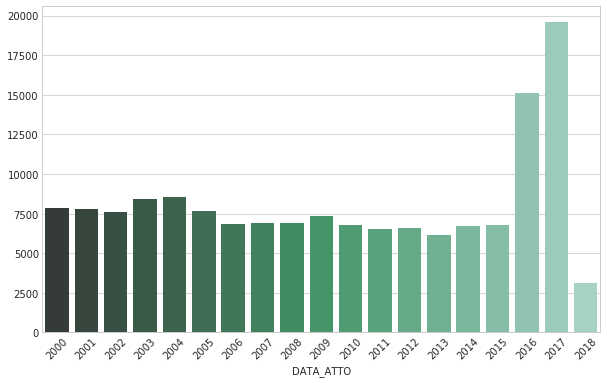

In [7]:
fig, ax = plt.subplots()
sns.barplot(acts_per_year.index, acts_per_year.values, palette="BuGn_d", ax=ax)
label_rotation(ax, 45)
fig.set_size_inches(10,6)
plt.show(fig)

The disitrbutions of the acts per year shows that there is an increase of acts for the years 2016 and 2017. From another point of view is interesting to see the distribution of acts per person.

In [8]:
print('acts distribution per person')
acts_per_person = df.groupby([df['PERSONA']])['CODICE_PRATICA'].count().sort_values(ascending=False)
print(acts_per_person[:10])

acts distribution per person
PERSONA
005549    8022
020411    4341
005045    3838
015534    3792
007505    3076
014002    2661
013692    2112
005642    2021
005070    1950
017792    1846
Name: CODICE_PRATICA, dtype: int64


We scale the values in the range [0:1] to make the visualization more clear.

In [9]:
acts_per_person_scaled = (acts_per_person - acts_per_person.min()) / (acts_per_person.max() - acts_per_person.min())
acts_per_person_scaled[:10]

PERSONA
005549    1.000000
020411    0.541080
005045    0.478369
015534    0.472634
007505    0.383369
014002    0.331629
013692    0.263184
005642    0.251839
005070    0.242987
017792    0.230021
Name: CODICE_PRATICA, dtype: float64

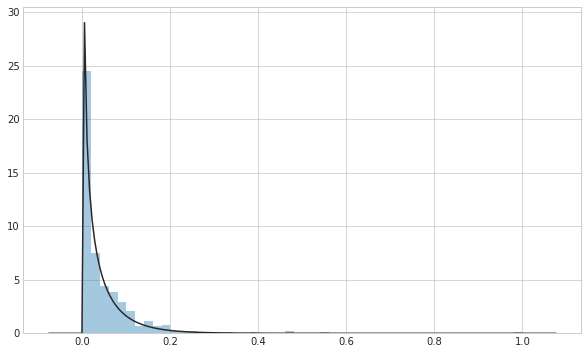

In [10]:
fig, ax = plt.subplots()
sns.distplot(acts_per_person_scaled.values, kde=False, ax=ax, fit=stats.beta)
fig.set_size_inches(10,6)
plt.show()

Here we can see that the distribution follows a beta distribution. In particular, we can see there are many values below the mean (as show below).

Taking into account the domain under analysis this means that there are persons that works in Regione Toscana from several years.

In [11]:
print('mean observations {}'.format(acts_per_person_scaled.mean()))
print('std observations {}'.format(acts_per_person_scaled.std()))

mean observations 0.04910370586488817
std observations 0.08381900223361802


In [12]:
(acts_per_person_scaled < acts_per_person_scaled.mean()).value_counts()

True     272
False    116
Name: CODICE_PRATICA, dtype: int64

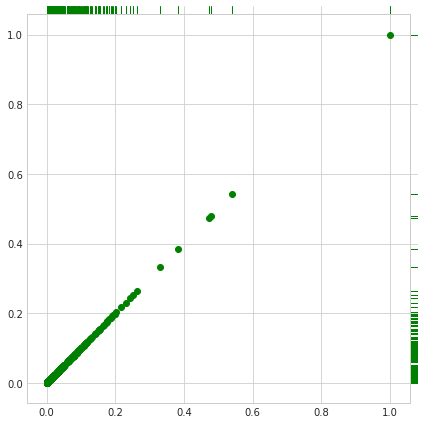

In [13]:
grid = sns.JointGrid(acts_per_person_scaled.values, acts_per_person_scaled.values, space=0, size=6, ratio=50)
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

If we consider the top 10 persons we can see for example that the first persons has 31 years of career with the same position in Regione Toscana.

In [14]:
acts_per_person_scaled[:10]

PERSONA
005549    1.000000
020411    0.541080
005045    0.478369
015534    0.472634
007505    0.383369
014002    0.331629
013692    0.263184
005642    0.251839
005070    0.242987
017792    0.230021
Name: CODICE_PRATICA, dtype: float64

Now let's group the acts per office. Also in this case we can see there are some office that published 14000 acts.

distribution acts per year
Top 10 
 UFFICIO_DG
50073    13890
50117    12279
50003     9776
50004     9732
50000     8331
50005     7515
01937     7192
50118     6399
50079     6087
50006     6047
Name: CODICE_PRATICA, dtype: int64
Last 10 
 UFFICIO_DG
99999    792
50112    745
50124    708
50201    654
50122    449
50044    445
50114    427
50113    353
50200    116
50026    106
Name: CODICE_PRATICA, dtype: int64


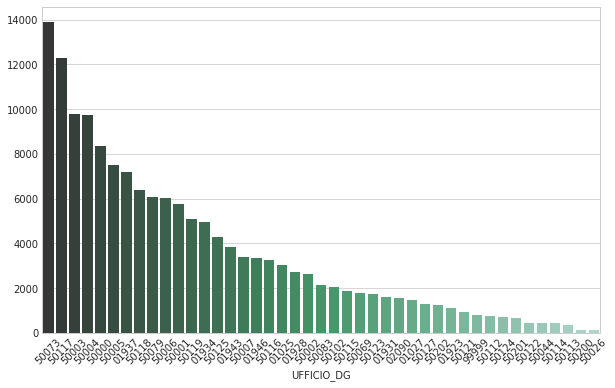

In [17]:
print('distribution acts per year')
acts_per_office = df.groupby([df['UFFICIO_DG']])['CODICE_PRATICA'].count()
acts_per_office = acts_per_office.sort_values(ascending=False)
print('Top 10 \n',acts_per_office[:10])
print('Last 10 \n',acts_per_office[-10:])

fig, ax = plt.subplots()
sns.barplot(acts_per_office.index, acts_per_office.values, palette="BuGn_d", 
            ax=ax, order=acts_per_office.index)
label_rotation(ax, 45)
fig.set_size_inches(10,6)
plt.show(fig)

In particular we can see that top structure is:

- "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D"

while the last is

- "DIREZIONE GENERALE DELLA GIUNTA REGIONALE"

As final exploration it would be interesting to see for the top person what is the distributions of acts per year

In [28]:
df_person = df[df['PERSONA'] == '005549']
acts_per_year_person = df_person.groupby([df_person['DATA_ATTO'].dt.year])['CODICE_PRATICA'].count()
acts_per_year_person

DATA_ATTO
2000     104
2001      93
2002      59
2003     122
2004     101
2005     109
2006     162
2007     128
2008     107
2009     133
2010     162
2011     179
2012     181
2013      62
2014     119
2015     122
2016    2412
2017    3192
2018     475
Name: CODICE_PRATICA, dtype: int64

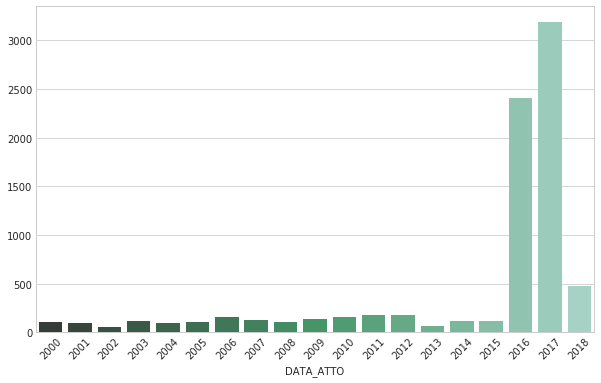

In [31]:
fig, ax = plt.subplots()
sns.barplot(acts_per_year_person.index, acts_per_year_person.values, palette="BuGn_d", 
            ax=ax, order=acts_per_year_person.index)
label_rotation(ax, 45)
fig.set_size_inches(10,6)
plt.show(fig)

Here we can see that apart 2016 and 2017 this person did in average the same number of acts.

It would be interesting to see the contribution of each person per office in order to spot:
- when a person moves from one office to another
- Who is in charge of an office (considering that if a person is in charge sign more acts than the others)

## Next Step

After the data exploration the next steps of this notebook is to write a classification model able to predict the office that writes the act given the text in the subject (Oggetto) attribute.